In [7]:
import skimage.io as io

# Show the figures / plots inside the notebook
%matplotlib inline
from skimage.color import rgb2gray,rgb2hsv, rgba2rgb
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import random_noise
import numpy as np
from commonfunctions import *
from skimage import io, color, morphology
from skimage.measure import label, regionprops
from skimage.draw import polygon
from skimage import transform
from skimage.morphology import binary_closing
from scipy import ndimage
from skimage.morphology import remove_small_objects


from skimage.exposure import histogram
from matplotlib.pyplot import bar

In [3]:
pip install opencv-python


In [ ]:

# def get_mc_data(original):
    
#     if original is None:
#         mc_contours = []
#         tophat_norm = None
#         return mc_contours, tophat_norm
    
#     return mc_contours, tophat_norm

In [17]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



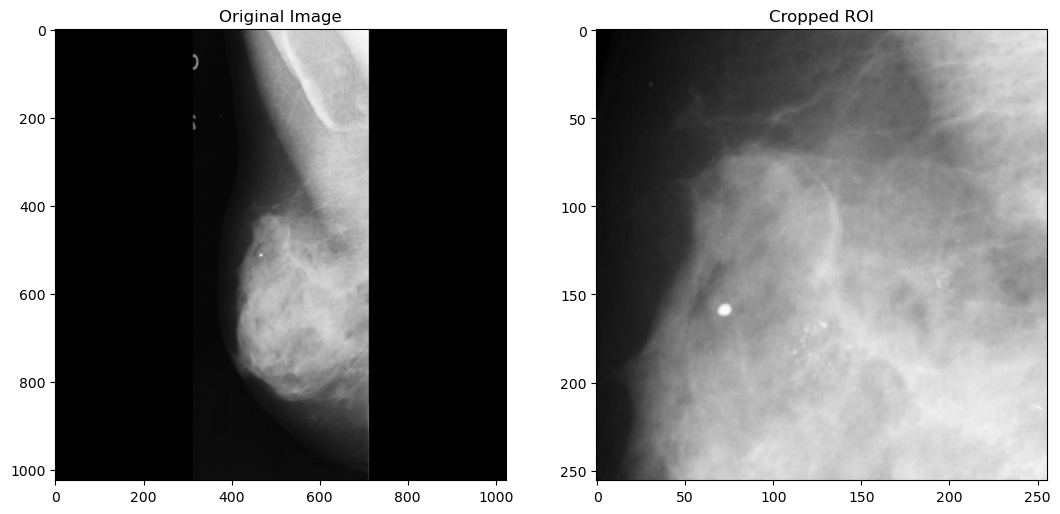

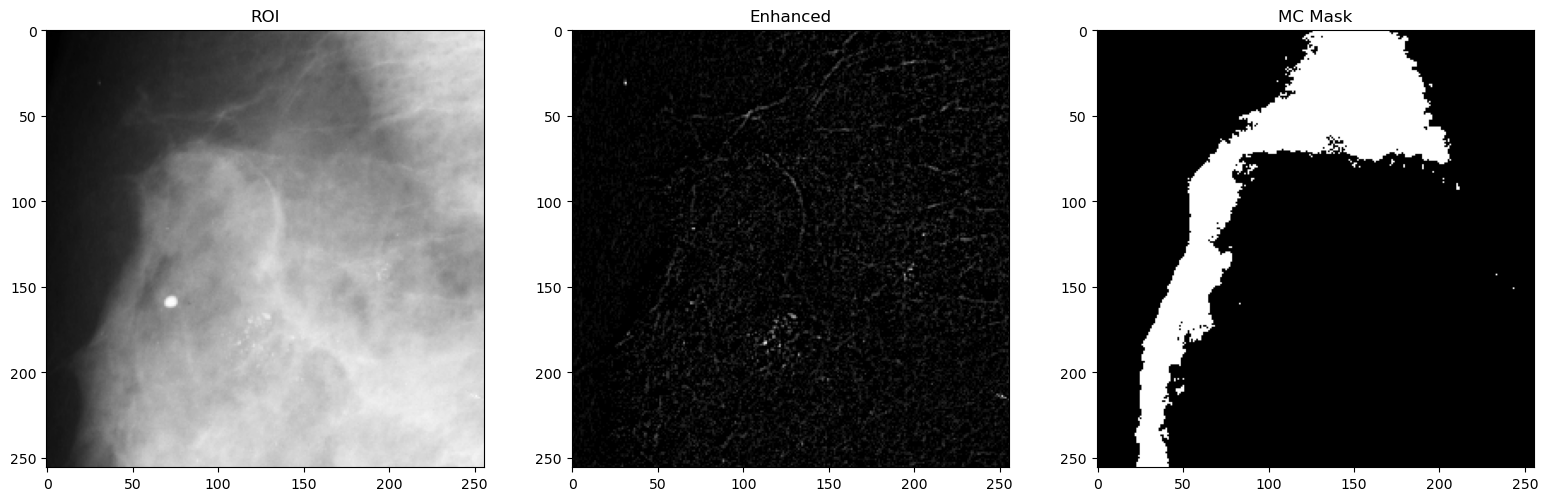

In [30]:
def load_image(path):
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found")
    return img

def image_crop(img, center_x, center_y, size=256):
    
    half = size // 2
    roi = img[
        center_y - half:center_y + half,
        center_x - half:center_x + half
    ]
    return roi

img = load_image("Dataset/all-mias/mdb223.pgm")
roi = image_crop(img, center_x=523, center_y=482)

show_images([img, roi], ["Original Image", "Cropped ROI"])

def tophat_func(img):
    
    se = cv2.getStructuringElement(
        cv2.MORPH_RECT, (3, 3)
    )
    
    eroded = cv2.erode(img, se, iterations=1)
    opened = cv2.dilate(eroded, se, iterations=1)
    tophat = cv2.subtract(img, opened)

    
    
    return tophat


def local_mean_std(img, window=5):
    """
    Compute local mean and std using sliding window
    Mean for brightness feature
    
    Microcalcifications -> high variation, high intensity
    Normal tissue -> smooth, low variation
    
    mean -> average brightness around the pixel
    standard deviation -> how much variation (texture) exists around it
    
    """
    kernel = np.ones((window, window), np.float32) / (window * window)
    
    mean = cv2.filter2D(img.astype(np.float32), -1, kernel)
    sqr_mean = cv2.filter2D((img.astype(np.float32))**2, -1, kernel)
    std = np.sqrt(sqr_mean - mean**2)

    return mean, std

def build_feature_vectors(original, enhanced, mean, std):
    """
    Build FV = [x1, x2, x3, x4] for each pixel
    """
    h, w = original.shape
    
    FV = np.zeros((h * w, 4), dtype=np.float32)
    
    FV[:, 0] = original.flatten()
    FV[:, 1] = enhanced.flatten()
    FV[:, 2] = mean.flatten()
    FV[:, 3] = std.flatten()
    
    return FV

def kmeans_segmentation(FV, k=2):
    # k is number of clusters
    kmeans = KMeans(
        n_clusters=k,
        init='random',
        max_iter=100,
        n_init=10,
        random_state=42
    )
    labels = kmeans.fit_predict(FV)
    return labels

def find_mc_cluster(FV, labels, enhanced):
    unique_labels = np.unique(labels)
    best_cluster = None
    best_score = -np.inf

    for lbl in unique_labels:
        idx = (labels == lbl)
        cluster_size = np.sum(idx)
        cluster_intensity = np.mean(enhanced.flatten()[idx])

        score = cluster_intensity / (cluster_size + 1)
        if score > best_score:
            best_score = score
            best_cluster = lbl

    return best_cluster


def build_mc_mask(labels, mc_cluster, shape):
    mask = (labels == mc_cluster).astype(np.uint8)
    return mask.reshape(shape)


def process_roi(roi):
    enhanced = tophat_func(roi)
    mean, std = local_mean_std(enhanced)
    FV = build_feature_vectors(roi, enhanced, mean, std)

    labels = kmeans_segmentation(FV, k=4)
    mc_cluster = find_mc_cluster(FV, labels, enhanced)
    mc_mask = build_mc_mask(labels, mc_cluster, roi.shape)

    return enhanced, mc_mask


enhanced, mc_mask = process_roi(roi)

show_images([roi, enhanced, mc_mask], ["ROI", "Enhanced", "MC Mask"])


Found 22 Microcalcification cases

Image        | Acc%     | Sens%    | Spec%    | Status
------------------------------------------------------------
mdb240       |  40.68 | 100.00 |  39.15 | ✓


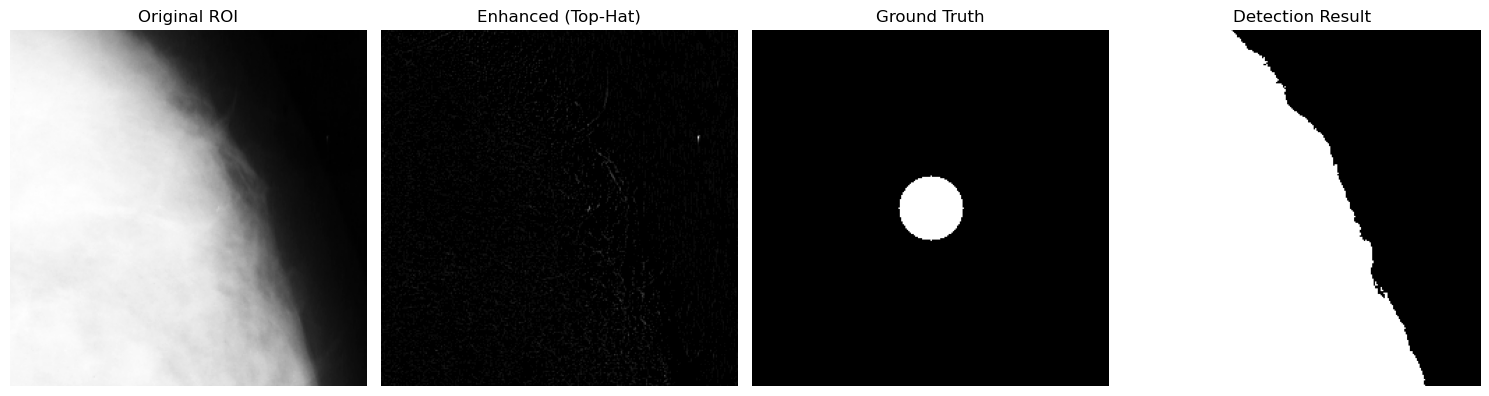

mdb231       |  52.44 |  40.97 |  53.61 | ✗
mdb239       |  14.70 | 100.00 |   7.61 | ✓
mdb223       |  20.48 | 100.00 |  20.35 | ✓
mdb256       |  73.74 |  61.84 |  74.57 | ✓
mdb249       |  26.79 | 100.00 |  17.74 | ✓
mdb219       |  44.81 |  98.25 |  42.58 | ✓
mdb211       |  16.04 | 100.00 |  15.36 | ✓
mdb214       |  74.53 |   0.00 |  74.96 | ✗
mdb238       |  26.97 | 100.00 |  25.95 | ✓
mdb239       |  38.52 | 100.00 |  36.62 | ✓
mdb241       |  46.27 |  70.62 |  44.47 | ✓
mdb252       |  89.38 |   0.00 |  91.69 | ✗
mdb253       |  12.75 | 100.00 |   9.35 | ✓
mdb249       |  43.83 |  86.03 |  33.54 | ✓
mdb226       |  38.12 | 100.00 |  37.98 | ✓
mdb248       |  55.67 | 100.00 |  55.46 | ✓
mdb218       |  23.68 | 100.00 |  23.45 | ✓
mdb226       |  24.48 | 100.00 |  22.15 | ✓
mdb222       |  46.47 |  71.92 |  46.11 | ✓
mdb209       |  29.99 |  34.67 |  27.33 | ✗
mdb223       |  26.29 | 100.00 |  23.21 | ✓

SUMMARY (22 images processed):
Average Accuracy:    39.39%
Average Sensitiv

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import pandas as pd
import os

# --------------------- Utilities ---------------------
def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found")
    return img

def image_crop(img, center_x, center_y, size=256):
    half = size // 2
    x1 = center_x - half
    x2 = center_x + half
    y1 = center_y - half
    y2 = center_y + half
    
    img_h, img_w = img.shape
    pad_top = abs(y1) if y1 < 0 else 0
    pad_bottom = (y2 - img_h) if y2 > img_h else 0
    pad_left = abs(x1) if x1 < 0 else 0
    pad_right = (x2 - img_w) if x2 > img_w else 0
    
    crop_y1 = max(0, y1)
    crop_y2 = min(img_h, y2)
    crop_x1 = max(0, x1)
    crop_x2 = min(img_w, x2)
    
    cropped = img[crop_y1:crop_y2, crop_x1:crop_x2]
    
    if pad_top > 0 or pad_bottom > 0 or pad_left > 0 or pad_right > 0:
        cropped = cv2.copyMakeBorder(cropped, pad_top, pad_bottom, 
                                    pad_left, pad_right, 
                                    cv2.BORDER_CONSTANT, value=0)
    return cropped

# --------------------- Preprocessing (Paper Method) ---------------------
def tophat_transform(img, se_size=3):
    """Top-Hat transform as described in paper"""
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (se_size, se_size))
    # Opening operation
    opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, se)
    # Top-Hat = Original - Opening
    tophat = cv2.subtract(img, opened)
    return tophat

def extract_window_features(img, window_size=5):
    """Extract mean and std features using 5x5 window (paper method)"""
    kernel = np.ones((window_size, window_size), np.float32) / (window_size * window_size)
    
    # Mean
    mean_img = cv2.filter2D(img.astype(np.float32), -1, kernel)
    
    # Standard deviation
    sqr_img = (img.astype(np.float32)) ** 2
    mean_sqr = cv2.filter2D(sqr_img, -1, kernel)
    std_img = np.sqrt(np.maximum(mean_sqr - mean_img**2, 0))
    
    return mean_img, std_img

# --------------------- Feature Vector Construction (Paper Method) ---------------------
def build_feature_vectors(original, enhanced, mean, std):
    """Build 4-dimensional feature vectors as in paper"""
    h, w = original.shape
    n_pixels = h * w
    
    FV = np.zeros((n_pixels, 4), dtype=np.float32)
    FV[:, 0] = original.flatten()
    FV[:, 1] = enhanced.flatten()
    FV[:, 2] = mean.flatten()
    FV[:, 3] = std.flatten()
    
    return FV

# --------------------- Clustering (Paper Method) ---------------------
def segment_with_kmeans(FV, n_clusters=2):
    """K-means segmentation as described in paper"""
    kmeans = KMeans(n_clusters=n_clusters, init='random', 
                   max_iter=100, n_init=10, random_state=42)
    labels = kmeans.fit_predict(FV)
    centers = kmeans.cluster_centers_
    return labels, centers

def identify_mc_cluster(labels, centers, FV, enhanced_flat):
    """
    Identify MC cluster using paper's criteria:
    - Minimum number of data with maximum gray level
    - Cluster separability
    """
    n_clusters = len(centers)
    cluster_scores = []
    
    for i in range(n_clusters):
        cluster_mask = (labels == i)
        cluster_size = np.sum(cluster_mask)
        
        # Mean intensity of cluster in enhanced image
        cluster_intensity = np.mean(enhanced_flat[cluster_mask])
        
        # Prefer smaller clusters with higher intensity (MCs are bright spots)
        # Score favors high intensity and penalizes large size
        score = cluster_intensity / (np.log(cluster_size + 2))
        cluster_scores.append((i, score, cluster_size, cluster_intensity))
    
    # Select cluster with highest score
    cluster_scores.sort(key=lambda x: x[1], reverse=True)
    mc_cluster_id = cluster_scores[0][0]
    
    return mc_cluster_id

# --------------------- Ground Truth Generation ---------------------
def create_ground_truth_mask(shape, center_x, center_y, radius):
    """Create circular ground truth mask"""
    mask = np.zeros(shape, dtype=np.uint8)
    h, w = shape
    
    Y, X = np.ogrid[:h, :w]
    dist_sq = (X - center_x)**2 + (Y - center_y)**2
    mask[dist_sq <= radius**2] = 1
    
    return mask

# --------------------- Evaluation (Paper Method) ---------------------
def evaluate_pixel_classification(pred_labels, gt_mask, mc_cluster_id, shape):
    """
    Evaluate as in paper: pixel-level classification
    - Sensitivity: TP / (TP + FN) 
    - Specificity: TN / (TN + FP)
    - Accuracy: (TP + TN) / Total
    """
    pred_mask = (pred_labels == mc_cluster_id).astype(np.uint8).reshape(shape)
    gt_flat = gt_mask.flatten()
    pred_flat = pred_mask.flatten()
    
    TP = np.sum((pred_flat == 1) & (gt_flat == 1))
    TN = np.sum((pred_flat == 0) & (gt_flat == 0))
    FP = np.sum((pred_flat == 1) & (gt_flat == 0))
    FN = np.sum((pred_flat == 0) & (gt_flat == 1))
    
    total = TP + TN + FP + FN
    
    sensitivity = TP / (TP + FN + 1e-10) * 100
    specificity = TN / (TN + FP + 1e-10) * 100
    accuracy = (TP + TN) / (total + 1e-10) * 100
    
    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN
    }

# --------------------- Main Processing Pipeline ---------------------
def process_roi_paper_method(roi, gt_center_x, gt_center_y, gt_radius):
    """
    Complete processing pipeline following paper's methodology
    """
    # Step 1: Top-Hat Enhancement
    enhanced = tophat_transform(roi, se_size=3)
    
    # Step 2: Window-based feature extraction
    mean_img, std_img = extract_window_features(enhanced, window_size=5)
    
    # Step 3: Build feature vectors
    FV = build_feature_vectors(roi, enhanced, mean_img, std_img)
    
    # Step 4: K-means clustering
    labels, centers = segment_with_kmeans(FV, n_clusters=2)
    
    # Step 5: Identify MC cluster
    mc_cluster_id = identify_mc_cluster(labels, centers, FV, enhanced.flatten())
    
    # Step 6: Create ground truth
    gt_mask = create_ground_truth_mask(roi.shape, gt_center_x, gt_center_y, gt_radius)
    
    # Step 7: Evaluate
    metrics = evaluate_pixel_classification(labels, gt_mask, mc_cluster_id, roi.shape)
    
    # For visualization
    pred_mask = (labels == mc_cluster_id).astype(np.uint8).reshape(roi.shape)
    
    return enhanced, pred_mask, gt_mask, metrics

# --------------------- Batch Processing ---------------------
def process_dataset(csv_path, visualize_first=True):
    """Process entire dataset"""
    df = pd.read_csv(csv_path)
    
    # Filter for CALC cases with valid coordinates
    calc_cases = df[(df['CLASS'] == 'CALC') & (df['X'].notna())].copy()
    print(f"Found {len(calc_cases)} Microcalcification cases\n")
    
    results = []
    
    print(f"{'Image':<12} | {'Acc%':<8} | {'Sens%':<8} | {'Spec%':<8} | Status")
    print("-" * 60)
    
    for idx, (index, row) in enumerate(calc_cases.iterrows()):
        ref_num = row['REF']
        image_path = row['PATH']
        
        try:
            raw_x = int(row['X'])
            raw_y = int(row['Y'])
            radius = int(row['RADIUS'])
        except (ValueError, KeyError):
            print(f"{ref_num:<12} | SKIP: Invalid data")
            continue
        
        # Handle Y-flip for MIAS
        center_y = 1024 - raw_y
        center_x = raw_x
        
        try:
            if not os.path.exists(image_path):
                print(f"{ref_num:<12} | ERROR: File not found")
                continue
            
            # Load and crop
            img = load_image(image_path)
            roi = image_crop(img, center_x, center_y, size=256)
            
            # ROI center is always at 128, 128
            roi_center = 128
            
            # Process using paper method
            enhanced, pred_mask, gt_mask, metrics = process_roi_paper_method(
                roi, roi_center, roi_center, radius
            )
            
            results.append({
                'ref': ref_num,
                'accuracy': metrics['accuracy'],
                'sensitivity': metrics['sensitivity'],
                'specificity': metrics['specificity']
            })
            
            status = "✓" if metrics['sensitivity'] > 50 else "✗"
            print(f"{ref_num:<12} | {metrics['accuracy']:>6.2f} | "
                  f"{metrics['sensitivity']:>6.2f} | {metrics['specificity']:>6.2f} | {status}")
            
            # Visualize first case
            if visualize_first and idx == 0:
                plt.figure(figsize=(15, 5))
                plt.subplot(141)
                plt.imshow(roi, cmap='gray')
                plt.title('Original ROI')
                plt.axis('off')
                
                plt.subplot(142)
                plt.imshow(enhanced, cmap='gray')
                plt.title('Enhanced (Top-Hat)')
                plt.axis('off')
                
                plt.subplot(143)
                plt.imshow(gt_mask, cmap='gray')
                plt.title('Ground Truth')
                plt.axis('off')
                
                plt.subplot(144)
                plt.imshow(pred_mask, cmap='gray')
                plt.title('Detection Result')
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
            
        except Exception as e:
            print(f"{ref_num:<12} | ERROR: {str(e)}")
    
    # Summary
    print("\n" + "="*60)
    if results:
        avg_acc = np.mean([r['accuracy'] for r in results])
        avg_sens = np.mean([r['sensitivity'] for r in results])
        avg_spec = np.mean([r['specificity'] for r in results])
        
        print(f"SUMMARY ({len(results)} images processed):")
        print(f"Average Accuracy:    {avg_acc:.2f}%")
        print(f"Average Sensitivity: {avg_sens:.2f}%")
        print(f"Average Specificity: {avg_spec:.2f}%")
    else:
        print("No images processed successfully")
    
    return results

# --------------------- Run ---------------------
if __name__ == "__main__":
    CSV_PATH = "train_dataset.csv"
    results = process_dataset(CSV_PATH, visualize_first=True)

In [ ]:
import cv2
import numpy as np
from sklearn.neural_network import MLPClassifier
import pandas as pd
import os

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError("Image not found")
    return img

def image_crop(img, cx, cy, size=256):
    h = size // 2
    x1, x2 = cx - h, cx + h
    y1, y2 = cy - h, cy + h

    H, W = img.shape
    crop = img[max(0,y1):min(H,y2), max(0,x1):min(W,x2)]

    return cv2.copyMakeBorder(
        crop,
        max(0,-y1), max(0,y2-H),
        max(0,-x1), max(0,x2-W),
        cv2.BORDER_CONSTANT, value=0
    )


def tophat_transform(img):
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    return cv2.subtract(img, cv2.morphologyEx(img, cv2.MORPH_OPEN, se))

def extract_window_features(img):
    k = np.ones((5,5), np.float32) / 25
    mean = cv2.filter2D(img.astype(np.float32), -1, k)
    mean_sq = cv2.filter2D(img.astype(np.float32)**2, -1, k)
    std = np.sqrt(np.maximum(mean_sq - mean**2, 0))
    return mean, std

def build_feature_vectors(o, e, m, s):
    return np.column_stack([o.flatten(), e.flatten(), m.flatten(), s.flatten()])


def create_gt(shape, cx, cy, r):
    Y, X = np.ogrid[:shape[0], :shape[1]]
    return ((X-cx)**2 + (Y-cy)**2 <= r*r).astype(np.uint8)

def evaluate(pred, gt):
    TP = np.sum((pred==1)&(gt==1))
    TN = np.sum((pred==0)&(gt==0))
    FP = np.sum((pred==1)&(gt==0))
    FN = np.sum((pred==0)&(gt==1))

    acc = (TP+TN)/(TP+TN+FP+FN+1e-10)*100
    sens = TP/(TP+FN+1e-10)*100
    spec = TN/(TN+FP+1e-10)*100
    return acc, sens, spec

# =====================================================
# Feature Extraction From ROI
# =====================================================
def extract_features(roi, gt):
    enh = tophat_transform(roi)
    mean, std = extract_window_features(enh)
    FV = build_feature_vectors(roi, enh, mean, std)
    return FV, gt.flatten()

# =====================================================
# Dataset Balancing
# =====================================================
def balance(X, y):
    mc = X[y==1]
    normal = X[y==0]

    keep = min(len(normal), len(mc)*3)
    normal = normal[np.random.choice(len(normal), keep, replace=False)]

    Xb = np.vstack([mc, normal])
    yb = np.hstack([np.ones(len(mc)), np.zeros(len(normal))])

    idx = np.random.permutation(len(Xb))
    return Xb[idx], yb[idx]

# =====================================================
# AMMLP
# =====================================================
class AMMLP:
    def __init__(self):
        self.net = MLPClassifier(
            hidden_layer_sizes=(15,),
            activation='logistic',
            max_iter=500,
            learning_rate_init=0.01,
            random_state=42,
            early_stopping=True
        )

    def fit(self, X, y):
        self.net.fit(X, y)

    def predict(self, X):
        return self.net.predict(X)

# =====================================================
# ONE TRAINING – TWO EVALUATIONS
# =====================================================
def run_70_train_30_test(csv_path):
    df = pd.read_csv(csv_path)
    cases = df[(df['CLASS']=='CALC') & (df['X'].notna())].reset_index(drop=True)

    rois, gts = [], []

    for _, r in cases.iterrows():
        img = load_image(r['PATH'])
        roi = image_crop(img, int(r['X']), 1024-int(r['Y']))
        gt = create_gt(roi.shape, 128, 128, int(r['RADIUS']))
        rois.append(roi)
        gts.append(gt)

    n = len(rois)
    split = int(0.7 * n)

    # ---------------- TRAIN ON 70% ----------------
    FV_list, L_list = [], []
    for i in range(split):
        FV, lab = extract_features(rois[i], gts[i])
        FV_list.append(FV)
        L_list.append(lab)

    X = np.vstack(FV_list)
    y = np.hstack(L_list)
    X, y = balance(X, y)

    clf = AMMLP()
    clf.fit(X, y)

    # ---------------- EVALUATE 70% ----------------
    accs70, sens70, spec70 = [], [], []

    for i in range(split):
        FV, _ = extract_features(rois[i], gts[i])
        pred = clf.predict(FV).reshape(rois[i].shape)
        a,s,sp = evaluate(pred, gts[i])
        accs70.append(a)
        sens70.append(s)
        spec70.append(sp)

    # ---------------- EVALUATE 30% ----------------
    accs30, sens30, spec30 = [], [], []

    for i in range(split, n):
        FV, _ = extract_features(rois[i], gts[i])
        pred = clf.predict(FV).reshape(rois[i].shape)
        a,s,sp = evaluate(pred, gts[i])
        accs30.append(a)
        sens30.append(s)
        spec30.append(sp)

    # ---------------- RESULTS ----------------
    res70 = (np.mean(accs70), np.mean(sens70), np.mean(spec70))
    res30 = (np.mean(accs30), np.mean(sens30), np.mean(spec30))
    avg = np.mean([res70, res30], axis=0)

    print("\nTRAINED ON 70%")
    print("Results on 70% (Training set)")
    print(f"Accuracy:    {res70[0]:.2f}%")
    print(f"Sensitivity: {res70[1]:.2f}%")
    print(f"Specificity: {res70[2]:.2f}%")

    print("\nResults on 30% (Test set)")
    print(f"Accuracy:    {res30[0]:.2f}%")
    print(f"Sensitivity: {res30[1]:.2f}%")
    print(f"Specificity: {res30[2]:.2f}%")

    print("\nAVERAGE (70% + 30%)")
    print(f"Accuracy:    {avg[0]:.2f}%")
    print(f"Sensitivity: {avg[1]:.2f}%")
    print(f"Specificity: {avg[2]:.2f}%")


if __name__ == "__main__":
    run_70_train_30_test("train_dataset.csv")



TRAINED ON 70%
Results on 70% (Training set)
Accuracy:    93.96%
Sensitivity: 18.67%
Specificity: 98.55%

Results on 30% (Test set)
Accuracy:    92.04%
Sensitivity: 30.77%
Specificity: 97.66%

AVERAGE (70% + 30%)
Accuracy:    93.00%
Sensitivity: 24.72%
Specificity: 98.11%


In [1]:
def get_mc_data(roi):
    """
    Lightweight getter for MC extraction.
    Uses existing functions and keeps logic minimal.
    """

    if roi is None or roi.size == 0:
        return [], None

    # 1. Use existing enhancement
    tophat_norm = tophat_transform(roi)

    # 2. Simple binary map for MC candidates
    _, bw = cv2.threshold(
        tophat_norm,
        0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 3. Find contours (no extra processing)
    contours, _ = cv2.findContours(
        bw,
        cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE
    )

    return contours, tophat_norm
